In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import time
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

In [ ]:
def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache

In [ ]:
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z <= 0] = 0 
    assert (dZ.shape == Z.shape)
    
    return dZ

In [ ]:
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [ ]:
def initialize_parameters_deep(layer_dims):
    parameters = {}
    L = len(layer_dims)
    for i in range(1,L):
        parameters["W"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) / np.sqrt(layer_dims[i-1])*0.01
        parameters["b"+str(i)] = np.zeros((layer_dims[i], 1))
        
        assert(parameters['W' + str(i)].shape == (layer_dims[i], layer_dims[i-1]))
        assert(parameters['b' + str(i)].shape == (layer_dims[i], 1))
        
    return parameters

In [ ]:
def linear_forward(A, W, b):
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [ ]:
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [ ]:
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [ ]:
def compute_cost(AL, Y):
    m = 2829
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))   
    cost = np.squeeze(cost) 
    assert(cost.shape == ())
    
    return cost


In [ ]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [ ]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [ ]:
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    temp = AL.shape[0]
    Y = np.array([Y[0]]*temp) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads


In [ ]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [ ]:
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p


# optimization


In [ ]:
def initialize_velocity(parameters):
    L = len(parameters) // 2 
    v = {}
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))        
    return v

In [ ]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural networks
    for l in range(L):
        # compute velocities
        v["dW" + str(l+1)] = beta*v["dW" + str(l+1)] + (1 - beta)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta*v["db" + str(l+1)] + (1 - beta)*grads['db' + str(l+1)]
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v["db" + str(l+1)]
        
    return parameters, v

In [ ]:
def initialize_adam(parameters) :
    L = len(parameters) // 2 
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], parameters["b" + str(l+1)].shape[1]))
    
    return v, s

In [ ]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    
    L = len(parameters) // 2                 
    v_corrected = {}                         
    s_corrected = {}                         
    
    for l in range(L):
        v["dW" + str(l+1)] = beta1*v["dW" + str(l+1)] + (1 - beta1)*grads['dW' + str(l+1)]
        v["db" + str(l+1)] = beta1*v["db" + str(l+1)] + (1 - beta1)*grads['db' + str(l+1)]
        
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1 - beta1**t)
        
        s["dW" + str(l+1)] = beta2*s["dW" + str(l+1)] + (1 - beta2)*np.square(grads['dW' + str(l+1)])
        s["db" + str(l+1)] = beta2*s["db" + str(l+1)] + (1 - beta2)*np.square(grads['db' + str(l+1)])
        
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1 - beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1 - beta2**t)
        
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)])+epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)])+epsilon)
        
    return parameters, v, s


In [ ]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    np.random.seed(seed)            # To make your "random" minibatches the same as ours
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))

    num_complete_minibatches = m//mini_batch_size # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X = shuffled_X[:, k*mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k*mini_batch_size : (k+1)*mini_batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    

    if m % mini_batch_size != 0:
        
        mini_batch_X = shuffled_X[:, int(m/mini_batch_size)*mini_batch_size : ]
        mini_batch_Y = shuffled_Y[:, int(m/mini_batch_size)*mini_batch_size : ]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

# Load dataset

In [ ]:
df  = pd.read_csv('/content/hypothyroid.csv')

In [ ]:
df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,P


In [ ]:
df.shape

(3772, 30)

In [ ]:
df.describe().T

,count,unique,top,freq
age,3772,94,59,95
sex,3772,3,F,2480
on thyroxine,3772,2,f,3308
query on thyroxine,3772,2,f,3722
on antithyroid medication,3772,2,f,3729
sick,3772,2,f,3625
pregnant,3772,2,f,3719
thyroid surgery,3772,2,f,3719
I131 treatment,3772,2,f,3713
query hypothyroid,3772,2,f,3538


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on thyroxine               3772 non-null   object
 3   query on thyroxine         3772 non-null   object
 4   on antithyroid medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid surgery            3772 non-null   object
 8   I131 treatment             3772 non-null   object
 9   query hypothyroid          3772 non-null   object
 10  query hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [ ]:
df["binaryClass"].value_counts()

P    3481
N     291
Name: binaryClass, dtype: int64

In [ ]:
df["binaryClass"]=df["binaryClass"].map({"P":0,"N":1})

In [ ]:
df["pregnant"].value_counts()

f    3719
t      53
Name: pregnant, dtype: int64

In [ ]:
df=df.replace({"t":1,"f":0})

In [ ]:
df

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,0,0,0,0,0,0,0,0,...,1,125,1,1.14,1,109,0,?,SVHC,0
1,23,F,0,0,0,0,0,0,0,0,...,1,102,0,?,0,?,0,?,other,0
2,46,M,0,0,0,0,0,0,0,0,...,1,109,1,0.91,1,120,0,?,other,0
3,70,F,1,0,0,0,0,0,0,0,...,1,175,0,?,0,?,0,?,other,0
4,70,F,0,0,0,0,0,0,0,0,...,1,61,1,0.87,1,70,0,?,SVI,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30,F,0,0,0,0,0,0,0,0,...,0,?,0,?,0,?,0,?,other,0
3768,68,F,0,0,0,0,0,0,0,0,...,1,124,1,1.08,1,114,0,?,SVI,0
3769,74,F,0,0,0,0,0,0,0,0,...,1,112,1,1.07,1,105,0,?,other,0
3770,72,M,0,0,0,0,0,0,0,0,...,1,82,1,0.94,1,87,0,?,SVI,0


In [ ]:
df['sex'].isnull().sum()

0

In [ ]:
df["TBG"].value_counts()


?    3772
Name: TBG, dtype: int64

In [ ]:
del df["TBG"]

In [ ]:
df=df.replace({"?":np.NAN})

In [ ]:
df.isnull().sum()

age                            1
sex                          150
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH measured                   0
TSH                          369
T3 measured                    0
T3                           769
TT4 measured                   0
TT4                          231
T4U measured                   0
T4U                          387
FTI measured                   0
FTI                          385
TBG measured                   0
referral source                0
binaryClass                    0
dtype: int64

In [ ]:
df["sex"].value_counts()

F    2480
M    1142
Name: sex, dtype: int64

In [ ]:
df=df.replace({"F":1,"M":0})

In [ ]:
df["referral source"].value_counts()

other    2201
SVI      1034
SVHC      386
STMW      112
SVHD       39
Name: referral source, dtype: int64

In [ ]:
del df["referral source"]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3771 non-null   object 
 1   sex                        3622 non-null   float64
 2   on thyroxine               3772 non-null   int64  
 3   query on thyroxine         3772 non-null   int64  
 4   on antithyroid medication  3772 non-null   int64  
 5   sick                       3772 non-null   int64  
 6   pregnant                   3772 non-null   int64  
 7   thyroid surgery            3772 non-null   int64  
 8   I131 treatment             3772 non-null   int64  
 9   query hypothyroid          3772 non-null   int64  
 10  query hyperthyroid         3772 non-null   int64  
 11  lithium                    3772 non-null   int64  
 12  goitre                     3772 non-null   int64  
 13  tumor                      3772 non-null   int64

In [ ]:
df["T3 measured"].value_counts()

1    3003
0     769
Name: T3 measured, dtype: int64

In [ ]:
df["TT4 measured"].value_counts()

1    3541
0     231
Name: TT4 measured, dtype: int64

In [ ]:
df["FTI measured"].value_counts()

1    3387
0     385
Name: FTI measured, dtype: int64

In [ ]:
df["TBG measured"].value_counts()

0    3772
Name: TBG measured, dtype: int64

In [ ]:
df["binaryClass"].value_counts()

0    3481
1     291
Name: binaryClass, dtype: int64

In [ ]:
df.dtypes

age                           object
sex                          float64
on thyroxine                   int64
query on thyroxine             int64
on antithyroid medication      int64
sick                           int64
pregnant                       int64
thyroid surgery                int64
I131 treatment                 int64
query hypothyroid              int64
query hyperthyroid             int64
lithium                        int64
goitre                         int64
tumor                          int64
hypopituitary                  int64
psych                          int64
TSH measured                   int64
TSH                           object
T3 measured                    int64
T3                            object
TT4 measured                   int64
TT4                           object
T4U measured                   int64
T4U                           object
FTI measured                   int64
FTI                           object
TBG measured                   int64
b

In [ ]:
cols = df.columns[df.dtypes.eq('object')]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df.dtypes

age                          float64
sex                          float64
on thyroxine                   int64
query on thyroxine             int64
on antithyroid medication      int64
sick                           int64
pregnant                       int64
thyroid surgery                int64
I131 treatment                 int64
query hypothyroid              int64
query hyperthyroid             int64
lithium                        int64
goitre                         int64
tumor                          int64
hypopituitary                  int64
psych                          int64
TSH measured                   int64
TSH                          float64
T3 measured                    int64
T3                           float64
TT4 measured                   int64
TT4                          float64
T4U measured                   int64
T4U                          float64
FTI measured                   int64
FTI                          float64
TBG measured                   int64
b

In [ ]:
df.isnull().sum()

age                            1
sex                          150
on thyroxine                   0
query on thyroxine             0
on antithyroid medication      0
sick                           0
pregnant                       0
thyroid surgery                0
I131 treatment                 0
query hypothyroid              0
query hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH measured                   0
TSH                          369
T3 measured                    0
T3                           769
TT4 measured                   0
TT4                          231
T4U measured                   0
T4U                          387
FTI measured                   0
FTI                          385
TBG measured                   0
binaryClass                    0
dtype: int64

In [ ]:
df['T4U measured'].mean()

0.8974019088016967

In [ ]:
df['T4U measured'].fillna(df['T4U measured'].mean(), inplace=True)
df['sex'].fillna(df['sex'].mean(), inplace=True)
df['age'].fillna(df['age'].mean(), inplace=True)

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')

In [ ]:
df['TSH'] = imputer.fit_transform(df[['TSH']])
df['T3'] = imputer.fit_transform(df[['T3']])
df['TT4'] = imputer.fit_transform(df[['TT4']])
df['T4U'] = imputer.fit_transform(df[['T4U']])
df['FTI'] = imputer.fit_transform(df[['FTI']])

In [ ]:
df.isnull().sum()

age                          0
sex                          0
on thyroxine                 0
query on thyroxine           0
on antithyroid medication    0
sick                         0
pregnant                     0
thyroid surgery              0
I131 treatment               0
query hypothyroid            0
query hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH measured                 0
TSH                          0
T3 measured                  0
T3                           0
TT4 measured                 0
TT4                          0
T4U measured                 0
T4U                          0
FTI measured                 0
FTI                          0
TBG measured                 0
binaryClass                  0
dtype: int64

In [ ]:
df

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,binaryClass
0,41.0,1.0,0,0,0,0,0,0,0,0,...,1,2.5000,1,125.000000,1,1.140,1,109.000000,0,0
1,23.0,1.0,0,0,0,0,0,0,0,0,...,1,2.0000,1,102.000000,0,0.995,0,110.469649,0,0
2,46.0,0.0,0,0,0,0,0,0,0,0,...,0,2.0135,1,109.000000,1,0.910,1,120.000000,0,0
3,70.0,1.0,1,0,0,0,0,0,0,0,...,1,1.9000,1,175.000000,0,0.995,0,110.469649,0,0
4,70.0,1.0,0,0,0,0,0,0,0,0,...,1,1.2000,1,61.000000,1,0.870,1,70.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,1.0,0,0,0,0,0,0,0,0,...,0,2.0135,0,108.319345,0,0.995,0,110.469649,0,0
3768,68.0,1.0,0,0,0,0,0,0,0,0,...,1,2.1000,1,124.000000,1,1.080,1,114.000000,0,0
3769,74.0,1.0,0,0,0,0,0,0,0,0,...,1,1.8000,1,112.000000,1,1.070,1,105.000000,0,0
3770,72.0,0.0,0,0,0,0,0,0,0,0,...,1,2.0000,1,82.000000,1,0.940,1,87.000000,0,0


In [ ]:
df.columns

Index(['age', 'sex', 'on thyroxine', 'query on thyroxine',
       'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery',
       'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium',
       'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH measured', 'TSH',
       'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U',
       'FTI measured', 'FTI', 'TBG measured', 'binaryClass'],
      dtype='object')

In [ ]:
import seaborn as sns

%matplotlib inline
sns.set(rc={'figure.figsize': [8, 8]}, font_scale=1.2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


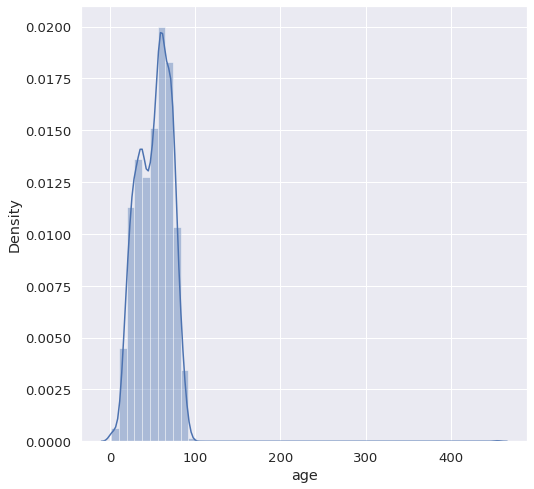

In [ ]:
sns.distplot(df['age'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


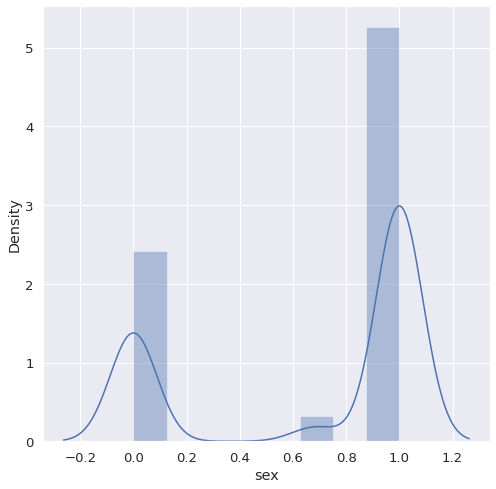

In [ ]:
sns.distplot(df['sex'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


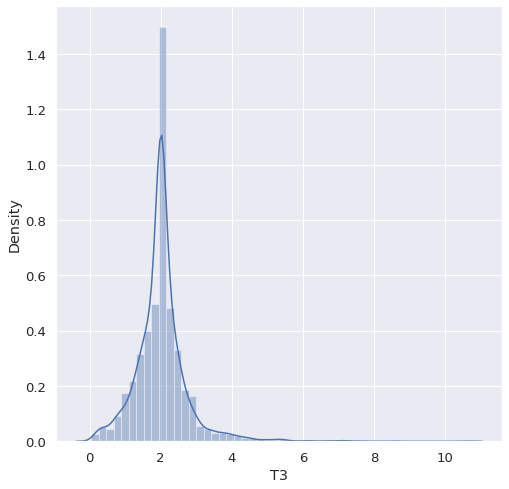

In [ ]:
sns.distplot(df['T3'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


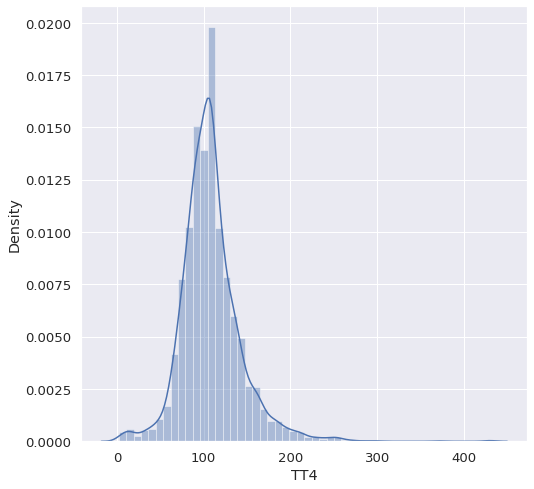

In [ ]:
sns.distplot(df['TT4'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


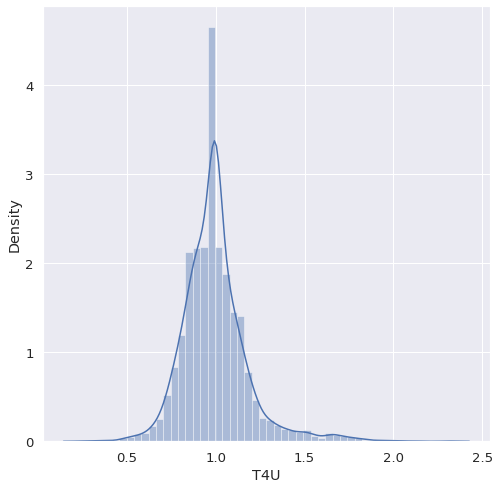

In [ ]:
sns.distplot(df['T4U'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


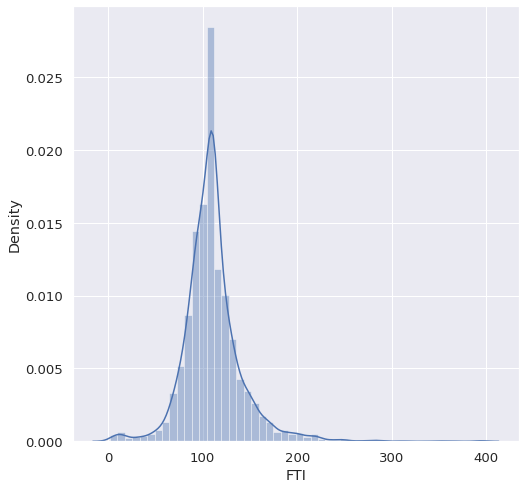

In [ ]:
sns.distplot(df['FTI'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


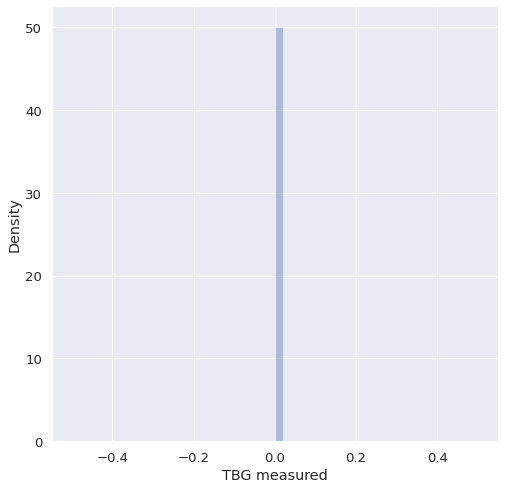

In [ ]:
sns.distplot(df['TBG measured'])

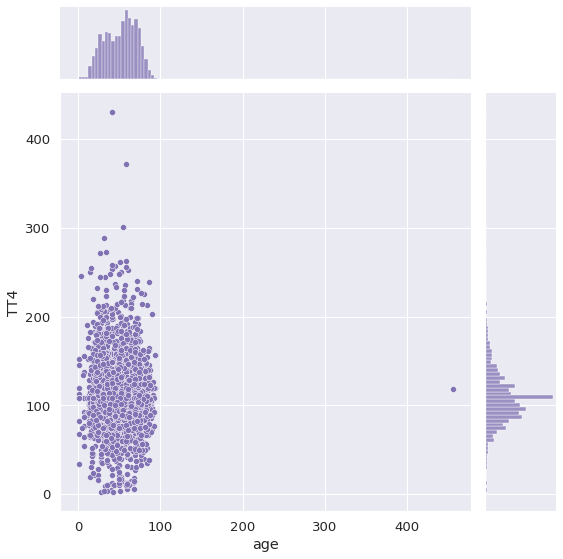

In [ ]:
sns.jointplot(x='age', y='TT4', data=df, kind='scatter', height=8, color='m')

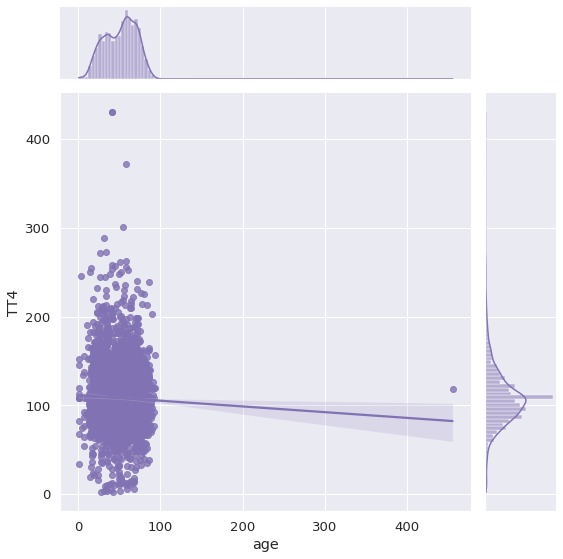

In [ ]:
sns.jointplot(x='age', y='TT4', data=df, kind='reg', height=8, color='m')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


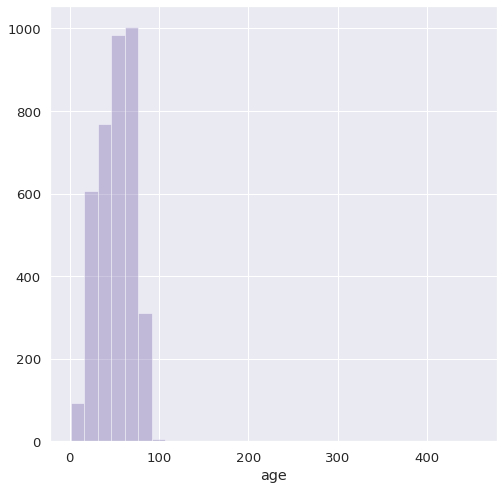

In [ ]:
sns.distplot(df['age'], kde=False, bins=30, color='m')

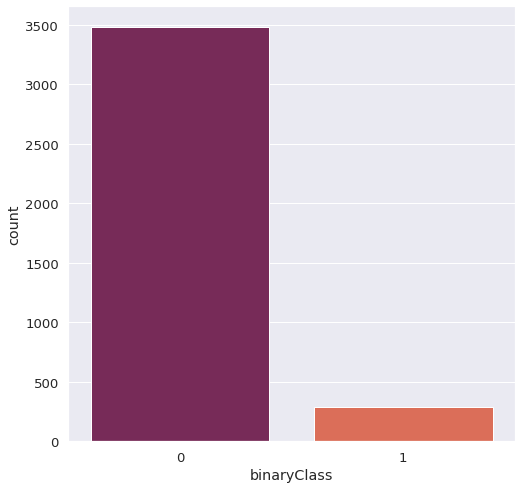

In [ ]:
sns.countplot(x='binaryClass', data=df, palette='rocket')

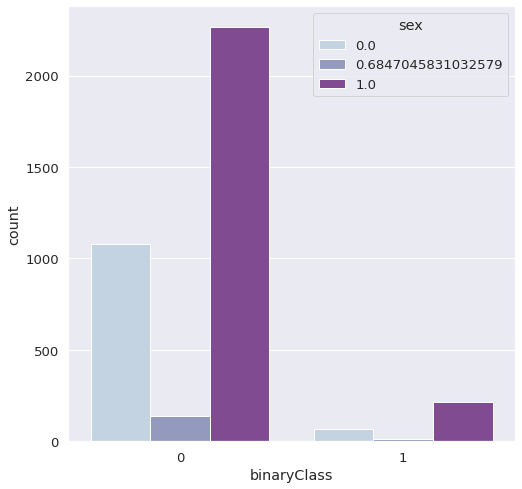

In [ ]:
sns.countplot(x='binaryClass', data=df, hue='sex', palette='BuPu')

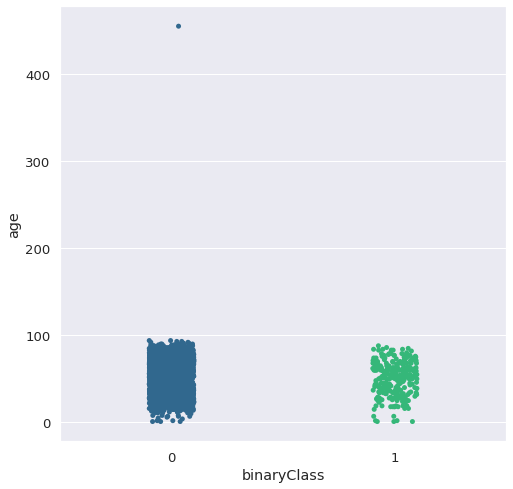

In [ ]:
sns.stripplot(x="binaryClass", y="age", data=df, palette="viridis")

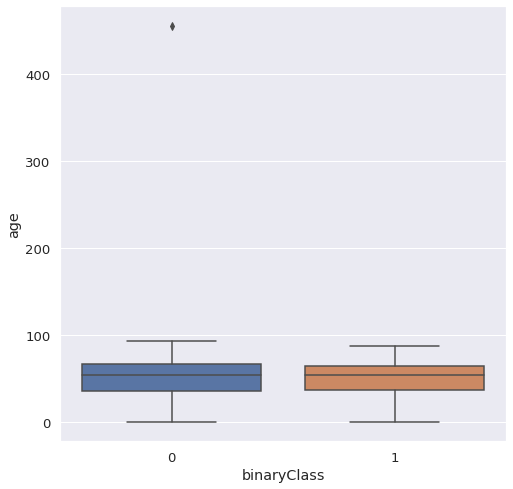

In [ ]:
sns.boxplot(x='binaryClass', y='age', data=df)

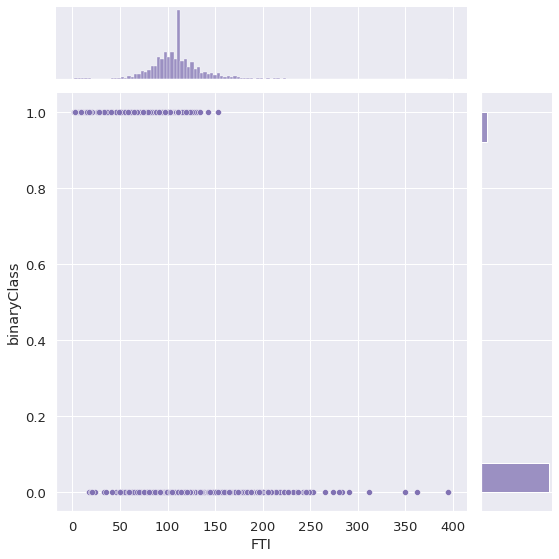

In [ ]:
sns.jointplot(x='FTI', y='binaryClass', data=df, kind='scatter', height=8, color='m')

In [ ]:
df_corr = df.corr()
df_corr

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,binaryClass
age,1.000000,0.003606,0.014563,-0.017870,-0.063881,0.079468,-0.113521,-0.029502,0.052704,0.039562,...,7.311084e-02,-2.149247e-01,6.750898e-02,-3.760948e-02,8.536127e-02,-1.575229e-01,8.453378e-02,5.001749e-02,NaN,-0.003174
sex,0.003606,1.000000,0.098510,-0.043533,0.030484,-0.005755,0.079550,0.036586,0.020372,0.046353,...,-7.500437e-02,6.275929e-02,-7.387180e-02,1.669887e-01,-4.934307e-02,2.255718e-01,-5.016697e-02,3.853089e-02,NaN,0.050808
on thyroxine,0.014563,0.098510,1.000000,0.005995,-0.002201,-0.042053,0.010152,0.037583,0.063373,0.094412,...,-1.450614e-01,6.484854e-03,2.496392e-02,2.128008e-01,3.885187e-02,4.636815e-02,3.828521e-02,1.857484e-01,NaN,-0.081060
query on thyroxine,-0.017870,-0.043533,0.005995,1.000000,-0.012446,0.012594,0.045247,0.005858,-0.014610,-0.029808,...,-3.340948e-02,-6.465900e-03,2.960328e-02,-4.702231e-03,3.155031e-02,4.384229e-04,3.141982e-02,-3.550040e-03,NaN,-0.007448
on antithyroid medication,-0.063881,0.030484,-0.002201,-0.012446,1.000000,-0.021624,0.072050,-0.012819,0.006589,-0.017264,...,1.094961e-02,7.921225e-02,-2.464939e-02,2.381055e-02,-2.953201e-02,6.036462e-02,-2.978795e-02,-1.660334e-02,NaN,-0.021689
sick,0.079468,-0.005755,-0.042053,0.012594,-0.021624,1.000000,-0.024040,-0.000762,-0.025384,0.027718,...,6.695144e-03,-7.647155e-02,-5.699708e-03,-3.700575e-02,9.399140e-03,-3.906941e-02,9.068046e-03,-2.118940e-02,NaN,-0.001749
pregnant,-0.113521,0.079550,0.010152,0.045247,0.072050,-0.024040,1.000000,-0.014251,-0.015048,-0.021364,...,2.686496e-02,1.811466e-01,2.109671e-02,1.724903e-01,3.294152e-02,3.347023e-01,3.280814e-02,-1.669842e-02,NaN,-0.034516
thyroid surgery,-0.029502,0.036586,0.037583,0.005858,-0.012819,-0.000762,-0.014251,1.000000,0.003104,-0.012026,...,-2.345292e-02,-2.414553e-02,3.049073e-02,-2.180623e-02,1.067220e-02,2.792243e-02,1.048764e-02,-3.182840e-02,NaN,-0.017633
I131 treatment,0.052704,0.020372,0.063373,-0.014610,0.006589,-0.025384,-0.015048,0.003104,1.000000,0.047296,...,1.504369e-04,1.205665e-02,3.219634e-02,-8.848056e-03,2.854012e-02,9.405826e-03,2.838493e-02,-1.681719e-02,NaN,0.003590
query hypothyroid,0.039562,0.046353,0.094412,-0.029808,-0.017264,0.027718,-0.021364,-0.012026,0.047296,1.000000,...,-6.354673e-02,-4.749603e-02,2.443261e-02,-9.012716e-03,1.451686e-02,1.383247e-02,1.409980e-02,-1.971919e-02,NaN,0.086282


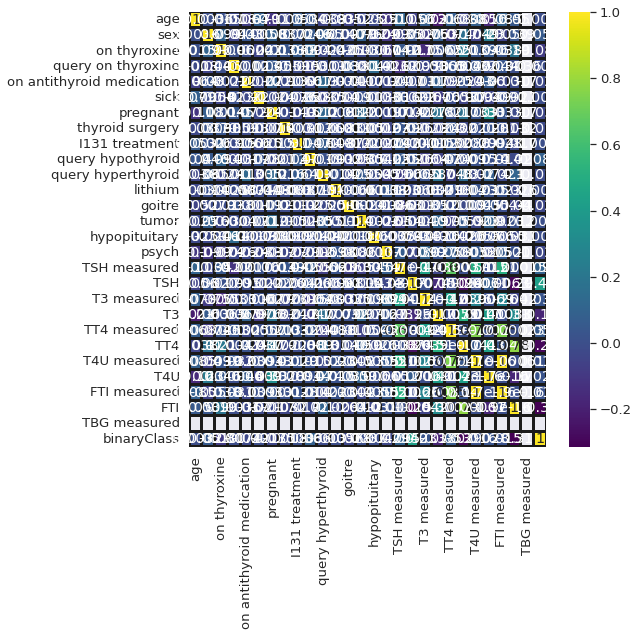

In [ ]:
sns.heatmap(df_corr, cmap='viridis', linecolor='k', linewidths=2, annot=True)

In [ ]:
x = df.drop('binaryClass', axis=1)
y = df['binaryClass']

In [ ]:
x

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured
0,41.0,1.0,0,0,0,0,0,0,0,0,...,1.300000,1,2.5000,1,125.000000,1,1.140,1,109.000000,0
1,23.0,1.0,0,0,0,0,0,0,0,0,...,4.100000,1,2.0000,1,102.000000,0,0.995,0,110.469649,0
2,46.0,0.0,0,0,0,0,0,0,0,0,...,0.980000,0,2.0135,1,109.000000,1,0.910,1,120.000000,0
3,70.0,1.0,1,0,0,0,0,0,0,0,...,0.160000,1,1.9000,1,175.000000,0,0.995,0,110.469649,0
4,70.0,1.0,0,0,0,0,0,0,0,0,...,0.720000,1,1.2000,1,61.000000,1,0.870,1,70.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30.0,1.0,0,0,0,0,0,0,0,0,...,5.086766,0,2.0135,0,108.319345,0,0.995,0,110.469649,0
3768,68.0,1.0,0,0,0,0,0,0,0,0,...,1.000000,1,2.1000,1,124.000000,1,1.080,1,114.000000,0
3769,74.0,1.0,0,0,0,0,0,0,0,0,...,5.100000,1,1.8000,1,112.000000,1,1.070,1,105.000000,0
3770,72.0,0.0,0,0,0,0,0,0,0,0,...,0.700000,1,2.0000,1,82.000000,1,0.940,1,87.000000,0


In [ ]:
y

0       0
1       0
2       0
3       0
4       0
       ..
3767    0
3768    0
3769    0
3770    0
3771    0
Name: binaryClass, Length: 3772, dtype: int64

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
x = sm.add_constant(x)
results = sm.OLS(y,x).fit()
results.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            binaryClass   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     48.57
Date:                Sat, 07 May 2022   Prob (F-statistic):          1.41e-213
Time:                        04:12:01   Log-Likelihood:                 179.17
No. Observations:                3772   AIC:                            -304.3
Df Residuals:                    3745   BIC:                            -136.0
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0334      0.058      0.578      0.563      -0.080       0.147
age                       -4.813e-05      0.000     -0.242      0.809      -0.000       0.000
sex                           0.0343      0.009      3.943      0.000       0.017       0.051
on thyroxine                 -0.0530      0.012     -4.339      0.000      -0.077      -0.029
query on thyroxine            0.0377      0.034      1.109      0.268      -0.029       0.104
on antithyroid medication    -0.0469      0.036     -1.299      0.194      -0.118       0.024
sick                         -0.0130      0.020     -0.660      0.509      -0.052       0.026
pregnant                     -0.0573      0.035     -1.654      0.098      -0.125       0.011
thyroid surgery              -0.0964      0.032     -2.989      0.003      -0.160      -0.033
I131 treatment               -0.0086      0.031     -0.279      0.780      -0.069       0.052
query hypothyroid             0.0718      0.016      4.520      0.000       0.041       0.103
query hyperthyroid            0.0258      0.016      1.593      0.111      -0.006       0.057
lithium                      -0.0436      0.055     -0.794      0.427      -0.151       0.064
goitre                       -0.0680      0.040     -1.693      0.091      -0.147       0.011
tumor                         0.0327      0.024      1.344      0.179      -0.015       0.080
hypopituitary                -0.2020      0.234     -0.862      0.389      -0.661       0.257
psych                        -0.0225      0.018     -1.258      0.208      -0.058       0.013
TSH measured                  0.1060      0.018      5.802      0.000       0.070       0.142
TSH                           0.0040      0.000     22.821      0.000       0.004       0.004
T3 measured                  -0.0199      0.011     -1.808      0.071      -0.041       0.002
T3                           -0.0216      0.006     -3.348      0.001      -0.034      -0.009
TT4 measured                  0.0202      0.029      0.704      0.481      -0.036       0.077
TT4                          -0.0016      0.000     -3.641      0.000      -0.002      -0.001
T4U measured                  0.1140      0.165      0.691      0.490      -0.209       0.437
T4U                           0.1602      0.055      2.920      0.004       0.053       0.268
FTI measured                 -0.1421      0.165     -0.863      0.388      -0.465       0.181
FTI                       -5.955e-05      0.000     -0.133      0.894      -0.001       0.001
TBG measured                       0          0        nan        nan           0           0
==============================================================================
Omnibus:                     2079.207   Durbin-Watson:                   2.009
Prob(Omnibu

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
x.shape

(3772, 28)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
x_train.shape

(2829, 28)

In [ ]:
y_train.shape

(2829,)

In [ ]:
type(y_train)

pandas.core.series.Series

In [ ]:
X_train = x_train.T

In [ ]:
X_train

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.25724849,  0.01615716, -1.01236279, ...,  0.65285999,
         1.04467711,  1.14263139],
       [ 0.69719436,  0.69719436,  0.69719436, ...,  0.69719436,
         0.69719436, -1.49535706],
       ...,
       [ 0.33666185,  0.33666185,  0.33666185, ...,  0.33666185,
         0.33666185,  0.33666185],
       [ 0.01223448, -1.78005475,  0.67255156, ...,  1.89885472,
         1.01843194,  1.89885472],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
X_train.shape

(28, 2829)

In [ ]:
Y_train = y_train.to_numpy()

In [ ]:
Y_train.shape

(2829,)

In [ ]:
Y_train = Y_train.reshape(1,2829)

In [ ]:
Y_train.shape

(1, 2829)

In [ ]:
X_train.shape

(28, 2829)

In [ ]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred=model.predict(x_test)
acc=accuracy_score(y_pred,y_test)

In [ ]:
print('Accuracy: ', acc)
print(classification_report(y_pred,y_test))
print(confusion_matrix(y_test,y_pred))

Accuracy:  0.9692470837751855
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       905
           1       0.57      0.97      0.72        38

    accuracy                           0.97       943
   macro avg       0.78      0.97      0.85       943
weighted avg       0.98      0.97      0.97       943

[[877   1]
 [ 28  37]]


In [ ]:
m=svm.LinearSVC(random_state=0, tol=1e-5)
m.fit(x_train,y_train)
y_svm_pred = m.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
print("Accuracy : ",accuracy_score(y_svm_pred,y_test))
print(classification_report(y_svm_pred,y_test))

Accuracy :  0.9639448568398727
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       910
           1       0.49      0.97      0.65        33

    accuracy                           0.96       943
   macro avg       0.75      0.97      0.82       943
weighted avg       0.98      0.96      0.97       943



In [ ]:
clf_Knn = KNeighborsClassifier(n_neighbors=5)
clf_Knn.fit(x_train, y_train)
y_Knn_pred=clf_Knn.predict(x_test)

In [ ]:
print("Accuracy : ",accuracy_score(y_Knn_pred,y_test))
print(classification_report(y_Knn_pred,y_test))

Accuracy :  0.9501590668080594
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       919
           1       0.32      0.88      0.47        24

    accuracy                           0.95       943
   macro avg       0.66      0.91      0.72       943
weighted avg       0.98      0.95      0.96       943



# L-Layer model

In [ ]:
def L_layer_model1(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    costs = []                    
    parameters = initialize_parameters_deep(layers_dims)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters
    

In [ ]:
layers_dims = [28,256,128,63,1]

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.582604
Cost after iteration 200: 0.506045
Cost after iteration 300: 0.452136
Cost after iteration 400: 0.413390
Cost after iteration 500: 0.384955
Cost after iteration 600: 0.363672
Cost after iteration 700: 0.347454
Cost after iteration 800: 0.334898
Cost after iteration 900: 0.325039
Cost after iteration 1000: 0.317200
Cost after iteration 1100: 0.310900
Cost after iteration 1200: 0.305788
Cost after iteration 1300: 0.301602
Cost after iteration 1400: 0.298150
Cost after iteration 1500: 0.295284
Cost after iteration 1600: 0.292889
Cost after iteration 1700: 0.290877
Cost after iteration 1800: 0.289178
Cost after iteration 1900: 0.287738
Cost after iteration 2000: 0.286511
Cost after iteration 2100: 0.285463
Cost after iteration 2200: 0.284565
Cost after iteration 2300: 0.283792
Cost after iteration 2400: 0.283126


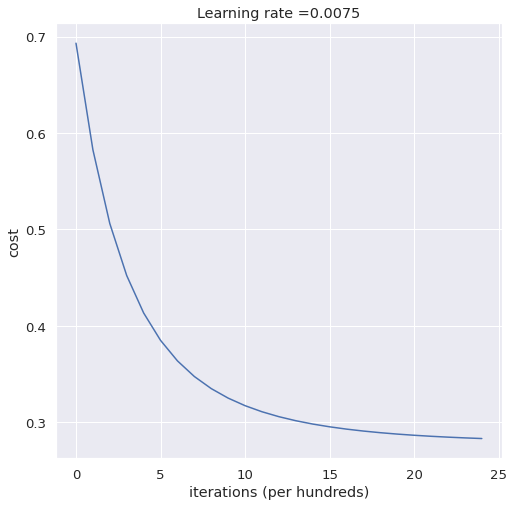

In [ ]:
parameters = L_layer_model1(X_train, Y_train, layers_dims, num_iterations = 2500, print_cost = True)

In [ ]:
pred_train = predict(X_train, Y_train, parameters)

Accuracy: 0.92011311417462


In [ ]:
x_test.shape

(943, 28)

In [ ]:
test_x = x_test.T

In [ ]:
test_x.shape

(28, 943)

In [ ]:
test_y = y_test.to_numpy()

In [ ]:
test_y.shape

(943,)

In [ ]:
test_y = test_y.reshape(1,943)

In [ ]:
test_y.shape

(1, 943)

In [ ]:
pred_train = predict(test_x, test_y, parameters)

Accuracy: 0.9310710498409331


In [ ]:
mini_batches = random_mini_batches(X_train, Y_train)

In [ ]:
len(mini_batches)

45

In [ ]:
mini_batches[44][0].shape

(28, 13)

In [ ]:
mini_batches[44][1].shape

(1, 13)

In [ ]:
def L_layer_model3(X, Y, layers_dims, optimizer, learning_rate = 0.0007, mini_batch_size = 64, beta = 0.9, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 1000, print_cost = True):
    costs = []                    
    parameters = initialize_parameters_deep(layers_dims)
    t = 0
    
    if optimizer == "gd":
        pass 
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    for i in range(0, num_epochs):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        if optimizer == "gd":
                parameters = update_parameters(parameters, grads, learning_rate)
        elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
        elif optimizer == "adam":
                t = t + 1 
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2,  epsilon)
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters
    

# batch gradient descent

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.681004
Cost after iteration 200: 0.669279
Cost after iteration 300: 0.657957
Cost after iteration 400: 0.647023
Cost after iteration 500: 0.636464
Cost after iteration 600: 0.626267
Cost after iteration 700: 0.616418
Cost after iteration 800: 0.606905
Cost after iteration 900: 0.597715


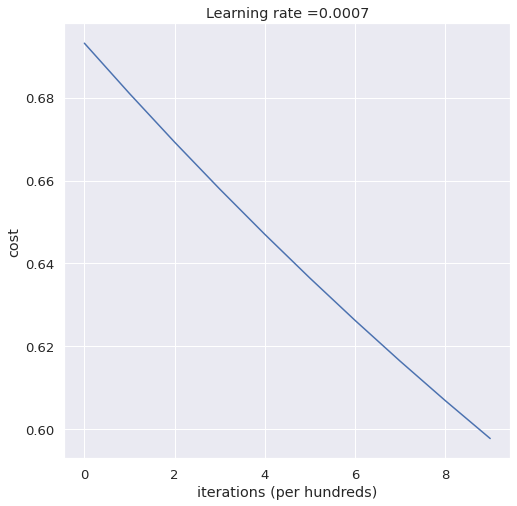

In [ ]:
parameters = L_layer_model3(X_train, Y_train, layers_dims, optimizer = "gd")

In [ ]:
predictions = predict(X_train, Y_train, parameters)

Accuracy: 0.92011311417462


In [ ]:
test = predict(test_x, test_y, parameters)

Accuracy: 0.9310710498409331


# momentum gradient descent 

In [ ]:
parameters = L_layer_model3(X_train, Y_train, layers_dims, optimizer = "momentum", beta = 0.9)

NameError: ignored

In [ ]:
predictions = predict(X_train, Y_train, parameters)

In [ ]:
test = predict(test_x, test_y, parameters)

# Adam optimizer

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.163384
Cost after iteration 200: 0.104217
Cost after iteration 300: 0.066901
Cost after iteration 400: 0.060901
Cost after iteration 500: 0.058526
Cost after iteration 600: 0.056852
Cost after iteration 700: 0.055299
Cost after iteration 800: 0.053856
Cost after iteration 900: 0.052414


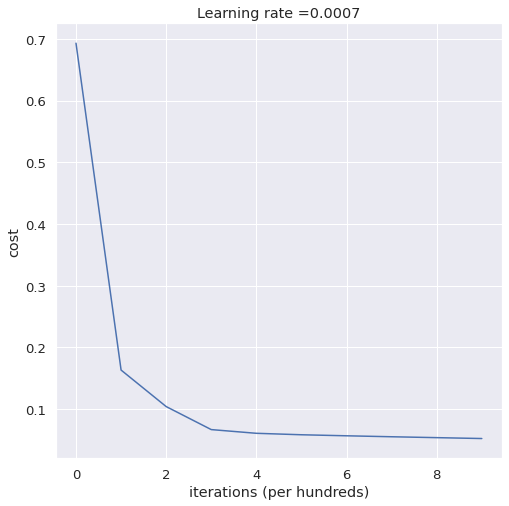

In [ ]:
parameters = L_layer_model3(X_train, Y_train, layers_dims, optimizer = "adam", beta1 = 0.92)

In [ ]:
predictions = predict(X_train, Y_train, parameters)

Accuracy: 0.9975256274301874


In [ ]:
test = predict(test_x, test_y, parameters)

Accuracy: 0.9862142099681868


In [ ]:
print(classification_report(test[0],test_y[0]))
print("Accuracy : ",accuracy_score(test[0],test_y[0]))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99       891
         1.0       0.80      1.00      0.89        52

    accuracy                           0.99       943
   macro avg       0.90      0.99      0.94       943
weighted avg       0.99      0.99      0.99       943

Accuracy :  0.9862142099681867
